In [1]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

from data_loaders import Plain_Dataset, eval_data_dataloader
from deep_emotion import Deep_Emotion
from generate_data import Generate_data

import cv2
import os
import math
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


data_path = 'ck_new/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# create train_val, test csv file
70% 10% 20%

In [2]:
np.random.seed(100)
with open('ck_plus.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    rows = [row for row in reader]

In [3]:
num_each = 9

random_array = np.arange(len(rows))
cnt_an = 0
cnt_di = 0
cnt_fe = 0
cnt_ha = 0
cnt_sa = 0
cnt_su = 0
cnt_ne = 0
loop = True

cnt = 0

st = []
st_lbl = []
idx = []
while loop:
    temp = np.random.choice(random_array)
    item = rows[temp][0]
    lbl = int(rows[temp][1])
    if item not in st:
        
        if lbl == 0 and cnt_an<num_each :
            cnt_an = cnt_an+1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl==1 and cnt_di<num_each:
            cnt_di = cnt_di+1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl==2 and cnt_fe<num_each:
            cnt_fe = cnt_fe+1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl==3 and cnt_ha<num_each:
            cnt_ha = cnt_ha +1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl == 4 and cnt_sa<num_each:
            cnt_sa = cnt_sa +1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl==5 and cnt_su<num_each:
            cnt_su = cnt_su+1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)
        elif lbl==6 and cnt_ne<num_each:
            cnt_ne = cnt_ne+1
            st_lbl.append(lbl)
            st.append(item)
            idx.append(temp)

#         print(len(st))
        if cnt_an==num_each and cnt_di==num_each and cnt_fe==num_each and cnt_ha==num_each and cnt_sa==num_each and cnt_su==num_each and cnt_ne==num_each:
            break

### test.csv

In [4]:
with open('test_ckplus.csv', 'w', encoding='UTF8',newline='') as test_ckplus:
    test_writer = csv.writer(test_ckplus)
    for i in range(len(rows)):
        if i in idx:
            test_writer.writerow(rows[i])

### train_val.csv

In [6]:
with open('train_val_ckplus.csv', 'w', encoding='UTF8',newline='') as train_ckplus:
    train_writer = csv.writer(train_ckplus)
    for i in range(len(rows)):
        if i not in idx :
            train_writer.writerow(rows[i])

# dataset

In [2]:
def plot_curve(train,test):
    plt.figure()                   # 设置图片信息 例如：plt.figure(num = 2,figsize=(640,480))
    plt.plot(train,'b',label = 'loss')        # epoch_losses 传入模型训练中的 loss[]列表,在训练过程中，先创建loss列表，将每一个epoch的loss 加进这个列表
    plt.plot(test,'g',label = 'loss')  
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()        #个性化图例（颜色、形状等）

class Jaffe_Dataset(Dataset):
    def __init__(self,csv_file,img_dir,datatype,transform):
        with open(csv_file,'r') as csvfile:
            rd = csv.reader(csvfile)
            self.data = [row for row in rd]

        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
#         img = Image.open(self.img_dir+self.data[idx][0])

        img = cv2.imread(self.img_dir+self.data[idx][0],0)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         print(img.shape)
        lables = np.array(int(self.data[idx][1]))
        lables = torch.from_numpy(lables).long()

        if self.transform :
            img = self.transform(img)
        return img,lables

    

traincsv_file = 'train_val_ckplus.csv'
train_img_dir = 'ck_new/'


# class: train and validate

In [3]:
def test_final(model, loss_fn, test_loader):
    
    model.eval()
    losses = 0.0   # ave loss of each epoch
    correct = 0    
    
    with torch.no_grad():
            
        for i,data in enumerate(test_loader,0):
#             print(i)
            inputs,targets = data
            outputs = model(inputs)
            loss = loss_fn(outputs,targets)
            losses += loss.item()
            _, predicted = torch.max(outputs, 1)

            correct += torch.sum(predicted == targets)            
            
            
            
    return losses/len(test_loader.sampler), correct/len(test_loader.sampler)


    
def train_final( model, loss_fn, train_loader, optimizer):
    
    model.train()
    losses = 0.0   # ave loss of each epoch
    correct = 0    
    
    for i,data in enumerate(train_loader,0):
        inputs,targets = data
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # records       
        losses += loss.item()
        _, preds = torch.max(outputs,1)
        correct += torch.sum(preds == targets.data)
        
    return losses/len(train_loader.sampler), correct/len(train_loader.sampler)


# run time

In [4]:
batchsize =128
transformation= transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
# transformation= transforms.Compose([transforms.ToTensor()])
train_dataset= Jaffe_Dataset(csv_file=traincsv_file, img_dir = train_img_dir, datatype = 'train', transform = transformation)

226 38


D:\Anacon_Install\lib\site-packages\torch\nn\functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
D:\Anacon_Install\lib\site-packages\torch\nn\functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch: 1 	Training Loss: 0.01708618 	Validation Loss 0.05004023 	Training Acuuarcy 20.80% 	Validation Acuuarcy 21.05%
Epoch: 2 	Training Loss: 0.01471245 	Validation Loss 0.04962715 	Training Acuuarcy 32.74% 	Validation Acuuarcy 26.32%
Epoch: 3 	Training Loss: 0.01213429 	Validation Loss 0.04950164 	Training Acuuarcy 53.54% 	Validation Acuuarcy 26.32%
Epoch: 4 	Training Loss: 0.01017128 	Validation Loss 0.04875878 	Training Acuuarcy 65.49% 	Validation Acuuarcy 31.58%
Epoch: 5 	Training Loss: 0.00873193 	Validation Loss 0.04767803 	Training Acuuarcy 71.68% 	Validation Acuuarcy 50.00%
Epoch: 6 	Training Loss: 0.00767846 	Validation Loss 0.04688977 	Training Acuuarcy 71.24% 	Validation Acuuarcy 65.79%
Epoch: 7 	Training Loss: 0.00689463 	Validation Loss 0.04565704 	Training Acuuarcy 74.78% 	Validation Acuuarcy 65.79%
Epoch: 8 	Training Loss: 0.00649450 	Validation Loss 0.04468031 	Training Acuuarcy 73.89% 	Validation Acuuarcy 73.68%
Epoch: 9 	Training Loss: 0.00520244 	Validation Loss 0.0

Epoch: 20 	Training Loss: 0.00318391 	Validation Loss 0.03261308 	Training Acuuarcy 90.71% 	Validation Acuuarcy 55.26%
Epoch: 21 	Training Loss: 0.00317632 	Validation Loss 0.02844336 	Training Acuuarcy 88.50% 	Validation Acuuarcy 63.16%
Epoch: 22 	Training Loss: 0.00303176 	Validation Loss 0.02553676 	Training Acuuarcy 89.38% 	Validation Acuuarcy 65.79%
Epoch: 23 	Training Loss: 0.00251749 	Validation Loss 0.02490341 	Training Acuuarcy 92.92% 	Validation Acuuarcy 65.79%
Epoch: 24 	Training Loss: 0.00251173 	Validation Loss 0.02535442 	Training Acuuarcy 92.04% 	Validation Acuuarcy 55.26%
Epoch: 25 	Training Loss: 0.00252006 	Validation Loss 0.02628784 	Training Acuuarcy 90.71% 	Validation Acuuarcy 60.53%
226 38
Epoch: 1 	Training Loss: 0.02127014 	Validation Loss 0.05054393 	Training Acuuarcy 20.35% 	Validation Acuuarcy 21.05%
Epoch: 2 	Training Loss: 0.01714937 	Validation Loss 0.05093295 	Training Acuuarcy 23.45% 	Validation Acuuarcy 21.05%
Epoch: 3 	Training Loss: 0.01604155 	Valida

Epoch: 14 	Training Loss: 0.00498984 	Validation Loss 0.03034432 	Training Acuuarcy 84.14% 	Validation Acuuarcy 78.38%
Epoch: 15 	Training Loss: 0.00488846 	Validation Loss 0.02830925 	Training Acuuarcy 80.62% 	Validation Acuuarcy 78.38%
Epoch: 16 	Training Loss: 0.00413632 	Validation Loss 0.02668184 	Training Acuuarcy 84.58% 	Validation Acuuarcy 75.68%
Epoch: 17 	Training Loss: 0.00405982 	Validation Loss 0.02196895 	Training Acuuarcy 85.02% 	Validation Acuuarcy 78.38%
Epoch: 18 	Training Loss: 0.00350785 	Validation Loss 0.02021969 	Training Acuuarcy 86.78% 	Validation Acuuarcy 86.49%
Epoch: 19 	Training Loss: 0.00338963 	Validation Loss 0.01892343 	Training Acuuarcy 87.22% 	Validation Acuuarcy 81.08%
Epoch: 20 	Training Loss: 0.00295446 	Validation Loss 0.01820925 	Training Acuuarcy 88.99% 	Validation Acuuarcy 81.08%
Epoch: 21 	Training Loss: 0.00321018 	Validation Loss 0.01605459 	Training Acuuarcy 88.55% 	Validation Acuuarcy 86.49%
Epoch: 22 	Training Loss: 0.00288504 	Validation

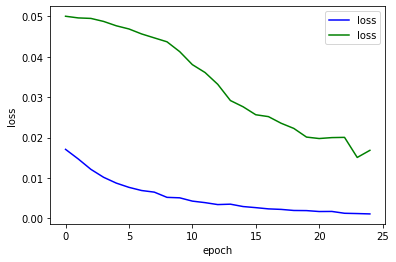

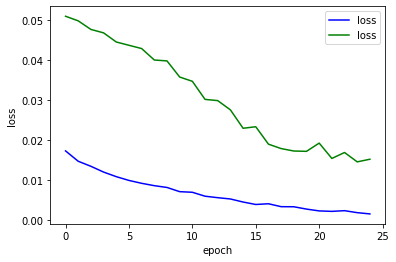

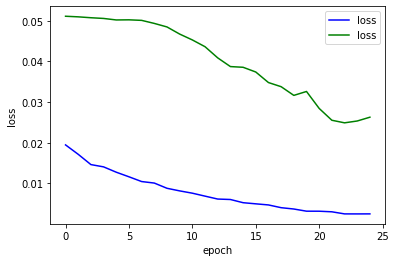

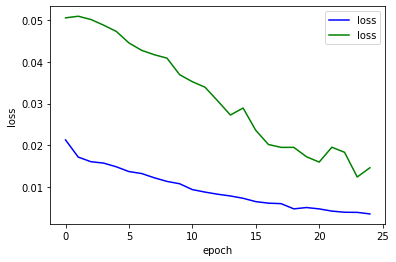

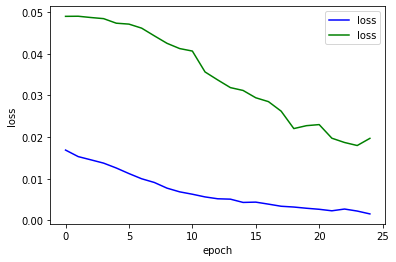

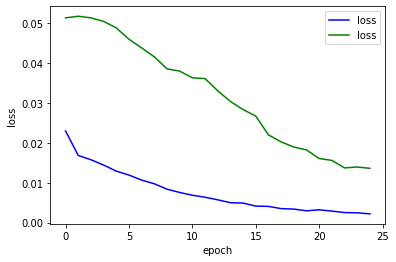

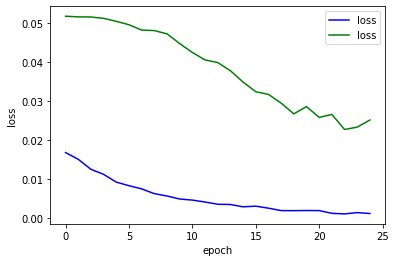

In [5]:
num_epochs = 25
k_folds = 7
kfold = KFold(n_splits=k_folds, shuffle=True)

l_rate = 0.005
loss_function = nn.CrossEntropyLoss()

# final_model = Deep_Emotion()

total_train_acc = []
total_val_acc = []
for fold_i, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
    print(len(train_ids),len(val_ids))
    train_loader = DataLoader(train_dataset, batch_size=batchsize, sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=batchsize, sampler=val_sampler)
    
    final_model = Deep_Emotion()
#     final_model.apply(reset_weights)
    optimizer = torch.optim.Adam(final_model.parameters(), lr=l_rate)
    
    train_acces = []
    val_acces = []
    train_losses = []
    val_losses = []
    
    for e in range(0,num_epochs):
        train_loss, train_acc = train_final(final_model,loss_function,train_loader,optimizer)
        val_loss, val_acc = test_final(final_model,loss_function,val_loader)
        
        train_acces.append(train_acc)
        val_acces.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.2f}% \tValidation Acuuarcy {:.2f}%'
                                                           .format(e+1, train_loss,val_loss,train_acc * 100, val_acc*100))

    total_train_acc.append(train_acces[-1])
    total_val_acc.append(val_acces[-1])
    plot_curve(train_losses,val_losses)

In [6]:
print("average validation accuracy:",np.mean(total_val_acc))
print("average training accuracy:",np.mean(total_train_acc))
total_val_acc

average validation accuracy: 0.7311522
average training accuracy: 0.93053734


[tensor(0.7895),
 tensor(0.7895),
 tensor(0.6053),
 tensor(0.7895),
 tensor(0.6579),
 tensor(0.7838),
 tensor(0.7027)]